# ML + Product Exercise: Churn Prediction as a PM

### 0. Executive Summary

**Business goal:** 
predict churn in next 30 days


**Business constraints:**
- False Negatives are expensive

- False Positives are cheap

- Model must be explainable

**Success definition:**

- High recall (“Out of all users who actually churned, how many did we catch?”)

- Acceptable precision (“Out of all users we flagged as churn risks, how many really churned?”)

- Explainable drivers

### 1. Setup & Data Preparation

#### 1.1 Load Packages

In [13]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# machine-learning stack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    recall_score,
    precision_score
)

# miscellaneous
import warnings
warnings.filterwarnings("ignore")


#### 1.2 Load Data

In [2]:
df = pd.read_csv('./data/synthetic_customer_churn.csv')
df.head()

,tenure_months,sessions_per_week,feature_usage,support_tickets,is_premium,churn
0,29,14,46,2,0,0
1,15,0,14,2,0,0
2,8,7,36,0,0,0
3,21,11,12,0,0,0
4,19,7,17,0,0,0


In [5]:
df.shape

(1500, 6)

##### 1.3 Initial Data Validation (Pre-Split)

In [4]:
# Looking for:
# String cleaning (lowercasing text, removing punctuation, fixing typos) - not needed
# Dropping duplicates - not needed
# Dropping irrelevant columns (ID's) - not needed
# Math operations (row-wise): converting units feet to meters / combining columns (e.g. calculating total cost by price * units sold)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   tenure_months      1500 non-null   int64
 1   sessions_per_week  1500 non-null   int64
 2   feature_usage      1500 non-null   int64
 3   support_tickets    1500 non-null   int64
 4   is_premium         1500 non-null   int64
 5   churn              1500 non-null   int64
dtypes: int64(6)
memory usage: 70.4 KB


In [ ]:

df.describe()

,tenure_months,sessions_per_week,feature_usage,support_tickets,is_premium,churn
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,18.514667,6.887333,25.492667,1.181333,0.276000,0.242000
std,10.268922,4.290172,14.207434,1.063895,0.447166,0.428437
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,10.000000,3.000000,13.000000,0.000000,0.000000,0.000000
50%,19.000000,7.000000,26.000000,1.000000,0.000000,0.000000
75%,28.000000,11.000000,38.000000,2.000000,1.000000,0.000000
max,35.000000,14.000000,49.000000,5.000000,1.000000,1.000000


In [ ]:
# Missing values?
df.isnull().sum()

tenure_months        0
sessions_per_week    0
feature_usage        0
support_tickets      0
is_premium           0
churn                0
dtype: int64

Dataset is clean and requires minimal preprocessing.
This allows us to focus on model choice and business trade-offs rather than data quality risks.

### 2. Exploratory Data Analysis (EDA)

- **Goal:** Understand churn patterns before modeling

#### 2.1 Target Distribution

In [8]:
df["churn"].value_counts(normalize=True)

churn
0    0.758
1    0.242
Name: proportion, dtype: float64

~24.2% of users churned

~75.8% of users were retained
meaning: The classes are (not extremely) imbalanced

Why imbalance affects modeling

- Models may bias toward predicting the majority class (0 = not churned)

- Evaluation metrics must focus on minority class performance

- Data splits must preserve churn proportions (stratify=y), Stratification ensures that our evaluation reflects real-world churn rates and prevents misleading performance estimates.

The target variable is moderately imbalanced, with approximately 24% of users churning.
This reflects a realistic business scenario in which churn is a minority but costly outcome.
As a result, accuracy alone is insufficient as an evaluation metric, and recall for churned users is prioritized.
During train–test splitting, stratification is applied to preserve class proportions and ensure reliable evaluation.

#### 2.2 Feature Distributions

Which behaviors look risky even before modeling?

For each feature we will conduct:

- Histogram / KDE

- Boxplot (outliers)

Features:

 1. tenure_months

2. sessions_per_week

3. feature_usage

4. support_tickets

5. is_premium

##### 2.2.1 Plot feature distributions

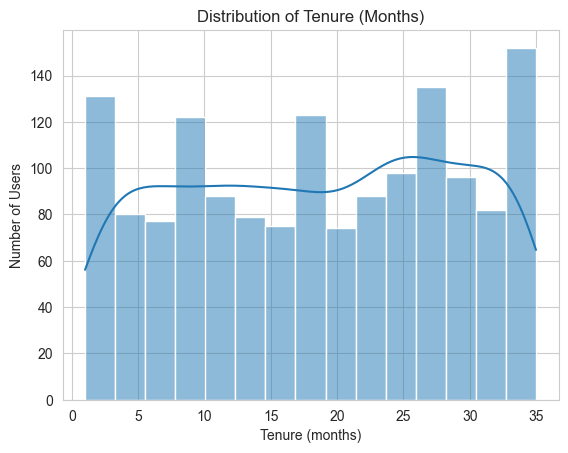

In [29]:
sns.histplot(df["tenure_months"], bins=15, kde=True)
plt.title("Distribution of Tenure (Months)")
plt.xlabel("Tenure (months)")
plt.ylabel("Number of Users")
plt.show()


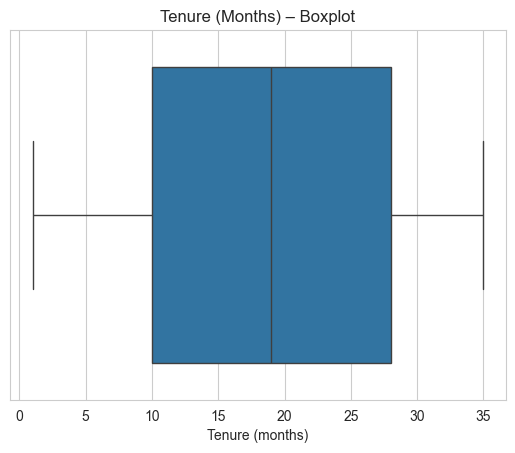

In [30]:
sns.boxplot(x=df["tenure_months"])
plt.title("Tenure (Months) – Boxplot")
plt.xlabel("Tenure (months)")
plt.show()


In [25]:
df["subscription_type"] = df["is_premium"].map({
    0: "Free / Basic",
    1: "Premium"
})

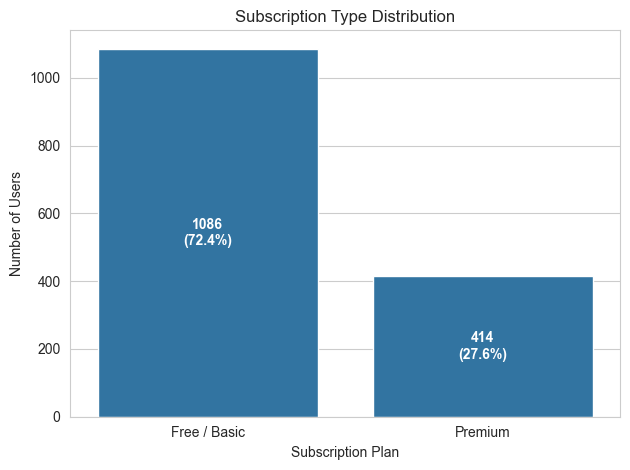

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the plot
ax = sns.countplot(x="subscription_type", data=df)
plt.title("Subscription Type Distribution")
plt.xlabel("Subscription Plan")
plt.ylabel("Number of Users")

# Add percentage labels inside bars
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(p.get_x() + p.get_width()/2, 
            p.get_height() / 2,  # Middle of the bar
            f'{count}\n({percentage})',
            ha='center',
            va='center',  # Vertical alignment: center
            fontsize=10,
            color='white',  # White text for contrast
            fontweight='bold')

plt.tight_layout()
plt.show()

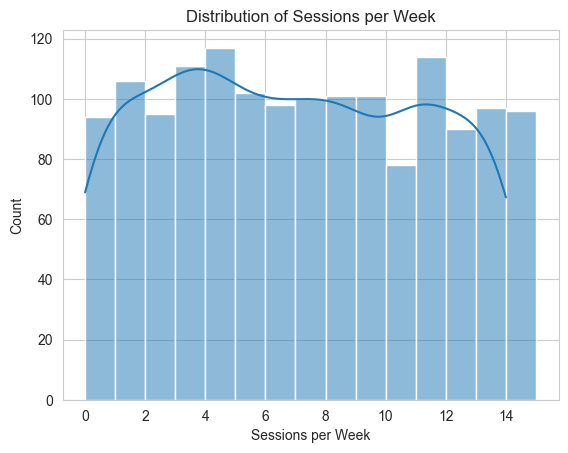

In [27]:
bins = np.arange(df["sessions_per_week"].min(),
                 df["sessions_per_week"].max() + 2)

sns.histplot(df["sessions_per_week"], bins=bins, kde=True)
plt.title("Distribution of Sessions per Week")
plt.xlabel("Sessions per Week")
plt.ylabel("Count")
plt.show()


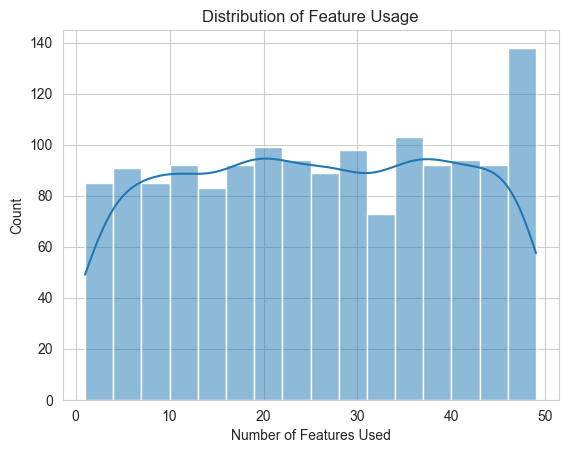

In [17]:
bins = np.arange(df["feature_usage"].min(),
                 df["feature_usage"].max() + 3, 3)

sns.histplot(df["feature_usage"], bins=bins, kde=True)
plt.title("Distribution of Feature Usage")
plt.xlabel("Number of Features Used")
plt.ylabel("Count")
plt.show()


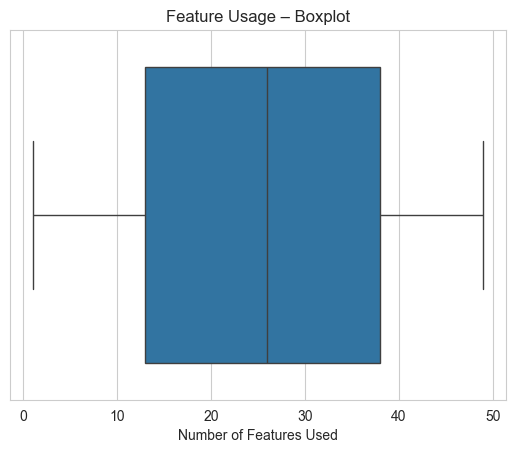

In [31]:
sns.boxplot(x=df["feature_usage"])
plt.title("Feature Usage – Boxplot")
plt.xlabel("Number of Features Used")
plt.show()

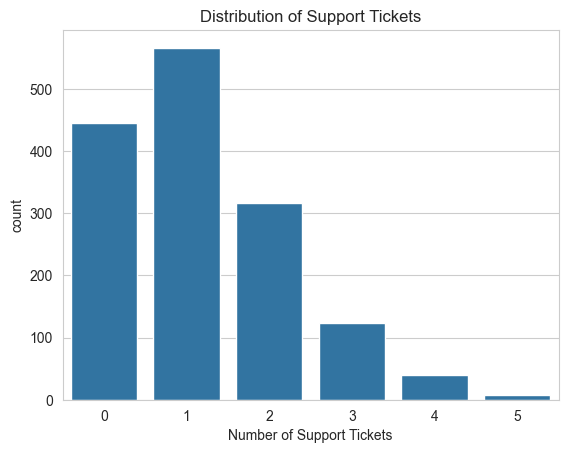

In [24]:
sns.countplot(x="support_tickets", data=df)
plt.xlabel("Number of Support Tickets")

plt.title("Distribution of Support Tickets")
plt.show()

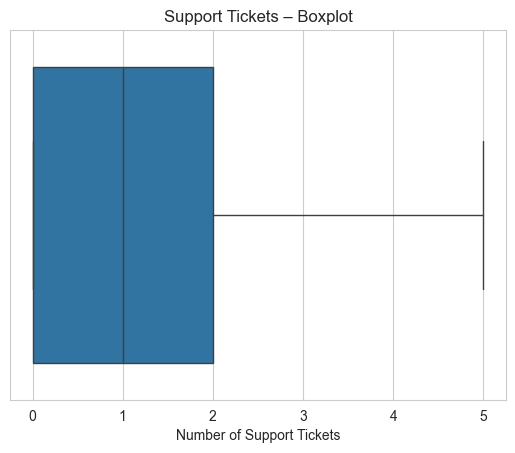

In [32]:
sns.boxplot(x=df["support_tickets"])
plt.title("Support Tickets – Boxplot")
plt.xlabel("Number of Support Tickets")
plt.show()

The skewed distribution of support tickets shows that while the majority of users have a smooth experience, a minority encounters repeated issues.
These high-ticket users represent a concentrated churn risk and an opportunity for targeted intervention.

#### 2.3 Feature vs Churn

**Goal:** Understand how churned users differ from retained users while being careful not to misinterpret cumulative

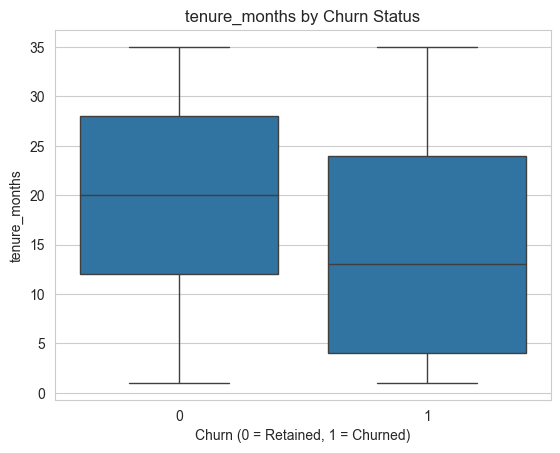

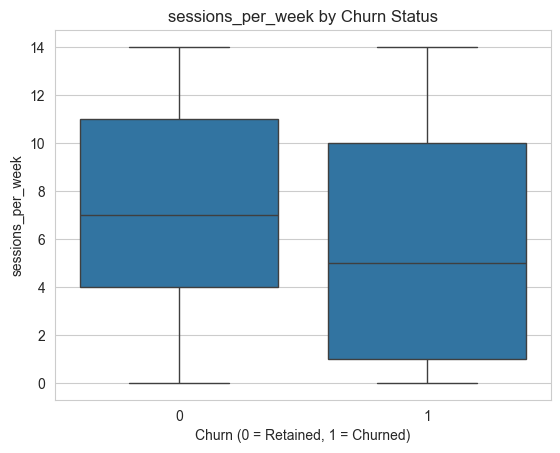

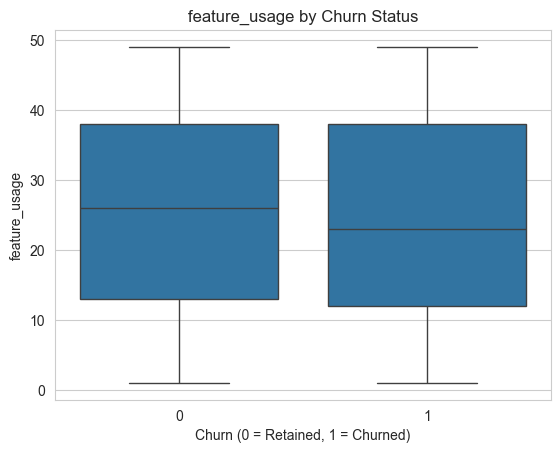

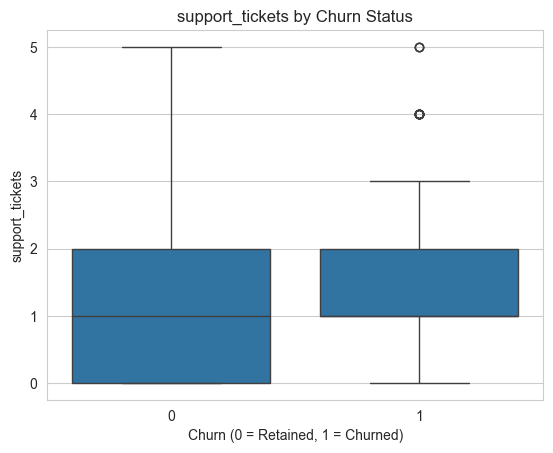

In [35]:
features = [
    "tenure_months",
    "sessions_per_week",
    "feature_usage",
    "support_tickets"
]

for col in features:
    sns.boxplot(x="churn", y=col, data=df)
    plt.title(f"{col} by Churn Status")
    plt.xlabel("Churn (0 = Retained, 1 = Churned)")
    plt.ylabel(col)
    plt.show()


Insights:

**tenure_months**
**Pattern:** Churned users have lower median tenure

**Interpretation:**

- Newer users are more vulnerable

- Early product experience is critical


**Insight:**

Churn risk is highest early in the user lifecycle.

------

**sessions_per_week**
**Pattern:** Churned users have lower session frequency

**Interpretation:**

- Engagement precedes retention

- Usage decline is an early warning signal


**Insight:**

Low engagement is a leading indicator of churn.

-----

**feature_usage**
**Pattern:** Churned users use fewer features

**Interpretation:**

- Shallow adoption → weaker product lock-in

**Insight:**

Users who don’t discover value breadth are more likely to churn.

----

**support_tickets**
**Pattern:** More tickets → more churn BUT!! ->

Users with longer tenure have had more time to create tickets
so:

Raw counts may reflect exposure, not dissatisfaction

**Insight:**

Some features, such as total support tickets or total feature usage, accumulate over time.
Therefore, higher values may partly reflect longer tenure rather than dissatisfaction or engagement intensity.
This is why we interpret these features together with tenure and rely on models to learn the combined effect rather than drawing conclusions from raw counts alone.

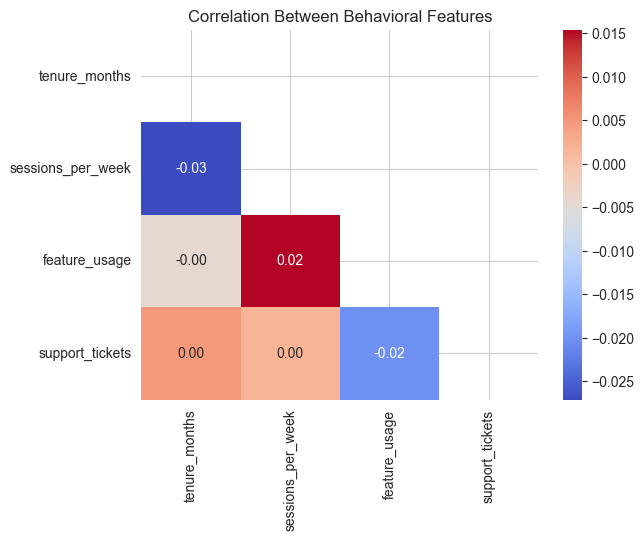

In [78]:
corr = df[features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Between Behavioral Features")
plt.show()


**Conclusions:**
- Correlation values are between -0.03 and +0.02

- This is effectively no linear correlation

We checked whether time on the platform artificially inflates other behavioral metrics and found no strong linear relationships, suggesting that each feature captures a distinct aspect of user behavior.

In [11]:
# Group means by churn
df.groupby("churn").mean()


,tenure_months,sessions_per_week,feature_usage,support_tickets,is_premium
churn,,,,,
0,19.665787,7.270888,25.685136,1.102902,0.320141
1,14.909091,5.685950,24.889807,1.426997,0.137741


**Final EDA Conclusion**

Churned users show some different behavior compared to retained users, such as lower engagement or more friction, but there is no single behavior that clearly separates the two groups. Most individual features overlap heavily between churned and retained users, which means that no single metric can reliably predict churn on its own. Instead, churn risk emerges from a combination of multiple behavioral signals. The correlation analysis shows that these signals are largely independent of each other, suggesting that they reflect real user behavior rather than simply how long someone has been using the product. This supports the use of a model that combines several features to identify users at risk of churn.

### 3. Train–Test Split

#### 3.1 Separate X / y

In [46]:
X = df[[
    "tenure_months",
    "sessions_per_week",
    "feature_usage",
    "support_tickets",
    "is_premium"
]]

y = df["churn"]

#### 3.2 Train–Test Split (with Stratification)

In [47]:
# Ensures churn rate is consistent across train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Because churn is a minority but costly outcome, we apply stratified splitting to ensure both training and test data reflect real-world churn proportions.

In [79]:
# Sanity check

print("Train churn rate:")
print(y_train.value_counts(normalize=True))

print("\nTest churn rate:")
print(y_test.value_counts(normalize=True))

Train churn rate:
churn
0    0.758333
1    0.241667
Name: proportion, dtype: float64

Test churn rate:
churn
0    0.756667
1    0.243333
Name: proportion, dtype: float64


### 4. Baseline Model

A baseline helps us measure whether added complexity is justified.


Recommended baseline: **Logistic Regression**

- Interpretable (coefficients → direction of effect)

- Probabilistic (supports threshold decisions later)

- Standard for churn problems

- Easy to explain to stakeholders

#### 4.1 Define Evaluation Priorities (Before Training)

**Business constraints recap:**

- False Negatives (missed churners) are very costly

- False Positives (contacting non-churners) are cheap

Therefore:

1. Primary metric: Recall (for churn = 1)

2. Secondary metric: Precision

3. Accuracy = context only

#### 4.2 Build the Baseline Pipeline

In [49]:
# We scale features because Logistic Regression is scale-sensitive.

baseline_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(random_state=42))
])

#### 4.3 Train the Baseline Model

In [50]:
baseline_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

#### 4.4 Make Predictions on Test Set

In [51]:
# Class predictions (default threshold = 0.5)

y_pred = baseline_pipeline.predict(X_test)


In [52]:
# Probabilities (for later threshold tuning)

y_proba = baseline_pipeline.predict_proba(X_test)[:, 1]


#### 4.5 Evaluate the Baseline Model

In [53]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[215,  12],
       [ 63,  10]])

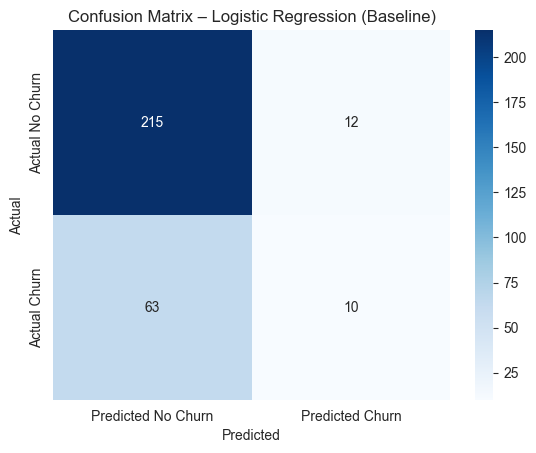

In [59]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"]
)

plt.title("Confusion Matrix – Logistic Regression (Baseline)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [55]:
# Recall & Precision
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Recall (churn=1): {recall:.3f}")
print(f"Precision (churn=1): {precision:.3f}")

Recall (churn=1): 0.137
Precision (churn=1): 0.455


In [58]:
# Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.95      0.85       227
           1       0.45      0.14      0.21        73

    accuracy                           0.75       300
   macro avg       0.61      0.54      0.53       300
weighted avg       0.70      0.75      0.70       300



#### 4.6 How to Interpret the Baseline Results

- Logistic Regression does learn signal

- But the default threshold is not business-aligned

- Recall improvement will be necessary

- Precision is already acceptable

Before looking for the right model:

Feature engineering was intentionally kept minimal to reduce complexity and maintain explainability. Given the small dataset and the goal of stakeholder transparency, we prioritized model behavior and business trade-offs over aggressive feature transformations.

### 5. Decision Tree Model

Why a Decision Tree now?

- Highly explainable (if–then rules)

- Captures non-linear relationships

- Often improves recall for minority classes

- Easy to explain to non-technical stakeholders

#### 5.1 Build the Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(
    max_depth=4,          
    min_samples_leaf=20,  # avoid tiny, noisy splits
    random_state=42
)

# We intentionally constrain model complexity to balance recall and explainability.

#### 5.2 Train the Model

In [62]:
tree_model.fit(X_train, y_train)


,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",20
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current n

#### 5.3 Make Predictions (default threshold)

In [63]:
y_pred_tree = tree_model.predict(X_test)


#### 5.4 Evaluate the Decision Tree

In [64]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_tree

array([[205,  22],
       [ 47,  26]])

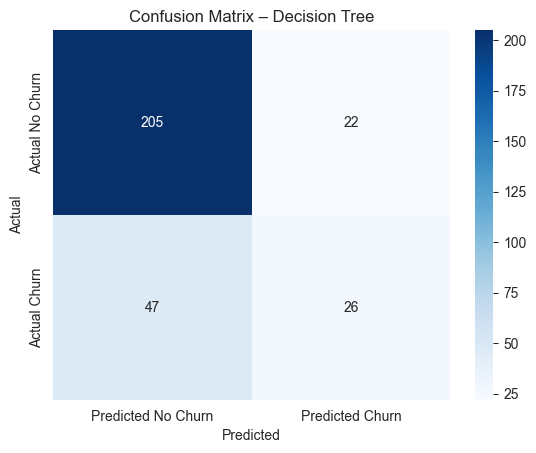

In [65]:
sns.heatmap(
    cm_tree,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"]
)

plt.title("Confusion Matrix – Decision Tree")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [66]:
# Recall & Precision
recall_tree = recall_score(y_test, y_pred_tree)
precision_tree = precision_score(y_test, y_pred_tree)

print(f"Recall (churn=1): {recall_tree:.3f}")
print(f"Precision (churn=1): {precision_tree:.3f}")

Recall (churn=1): 0.356
Precision (churn=1): 0.542


#### 5.5 How to Interpret the Results

- Higher recall

- Slightly lower precision

- More false positives (acceptable)

- Fewer false negatives (very good)

The decision tree is more aggressive in flagging at-risk users, which aligns better with the business goal of minimizing missed churners.

#### 5.6 Explainability Angle

The decision tree translates user behavior into a small number of intuitive rules, such as low engagement combined with short tenure, making it easy to explain to marketing and product teams.

#### 5.7 Interim Comparison (Baseline vs Tree)

| Model               | Recall (churn=1) | Precision (churn=1) | What it suggests                     |
| ------------------- | ---------------: | ------------------: | ------------------------------------ |
| Logistic Regression |            0.137 |               0.455 | Too conservative / misses churners   |
| Decision Tree       |            0.356 |               0.542 | Better alignment with churn patterns |


### 6. KNN Model

#### 6.1 Build + train

In [68]:
knn_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

knn_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",3

#### 6.2 Predict

In [69]:
y_pred_knn = knn_pipeline.predict(X_test)

#### 6.3 Evaluate

In [70]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("KNN confusion matrix:\n", cm_knn)

recall_knn = recall_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)

print(f"Recall (churn=1): {recall_knn:.3f}")
print(f"Precision (churn=1): {precision_knn:.3f}")

KNN confusion matrix:
 [[203  24]
 [ 54  19]]
Recall (churn=1): 0.260
Precision (churn=1): 0.442


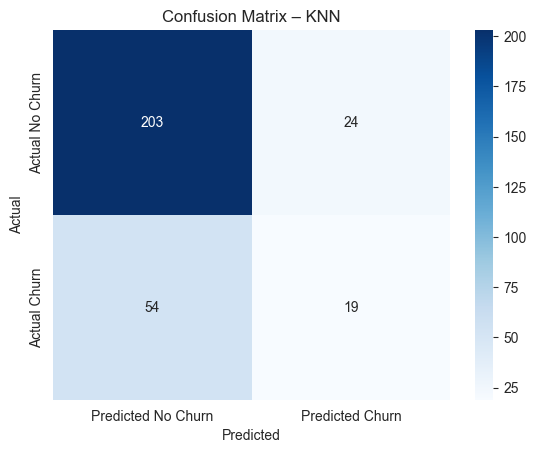

In [71]:
sns.heatmap(
    cm_knn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"]
)
plt.title("Confusion Matrix – KNN")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### 7. Choosing the Model

| Model               |    Recall | Precision | FN (missed churners) | TP (caught churners) |
| ------------------- | --------: | --------: | -------------------: | -------------------: |
| Logistic Regression |     0.137 |     0.455 |                   63 |                   10 |
| Decision Tree       | **0.356** | **0.542** |               **47** |               **26** |
| KNN                 |     0.260 |     0.442 |                   54 |                   19 |


Among the evaluated models, the **decision tree** best aligns with the business objective of minimizing missed churners while remaining explainable. It achieves the highest recall for churned users and improves precision relative to both logistic regression and KNN, making it the most effective and actionable option for proactive retention.


Explainability in this context means:

Can we explain why a user was flagged?

Can marketing act on it?

Can we defend it to leadership?

**Decision Tree advantage:**

- Produces clear behavioral rules

- Can be translated into:

1. onboarding triggers

2. engagement nudges

3. support interventions

For Example:

Users with short tenure and low weekly sessions are at significantly higher churn risk.

### 8. Threshold Tuning (Decision Tree)

Goal: Reduce False Negatives (missed churners), even if this increases False Positives (extra outreach).

#### 8.1 Get churn probabilities from the Decision Tree

In [ ]:
# We tune thresholds using probabilities, not class labels.
# We must look at probabilities first, because thresholds only make sense there.
y_proba_tree = tree_model.predict_proba(X_test)[:, 1]


#### 8.2 Define a small set of candidate thresholds

In [75]:
thresholds = [0.5, 0.4, 0.3]


#### 8.3 Evaluate recall & precision per threshold

In [76]:
results = []

for t in thresholds:
    y_pred_t = (y_proba_tree >= t).astype(int)
    
    results.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred_t),
        "precision": precision_score(y_test, y_pred_t),
        "confusion_matrix": confusion_matrix(y_test, y_pred_t)
    })

results


[{'threshold': 0.5,
  'recall': 0.3561643835616438,
  'precision': 0.5416666666666666,
  'confusion_matrix': array([[205,  22],
         [ 47,  26]])},
 {'threshold': 0.4,
  'recall': 0.4520547945205479,
  'precision': 0.5892857142857143,
  'confusion_matrix': array([[204,  23],
         [ 40,  33]])},
 {'threshold': 0.3,
  'recall': 0.5753424657534246,
  'precision': 0.5753424657534246,
  'confusion_matrix': array([[196,  31],
         [ 31,  42]])}]

#### 8.4 How to read the results

1. Option A — Conservative (0.5)

- Fewer contacts

- Miss many churners

- Not aligned with business goal

2. Option B — Balanced (0.4)

- Strong recall improvement

- Precision remains high

- Safe recommendation

3. Option C — Aggressive (0.3)

- Maximum churn prevention

- More outreach

- Best if marketing capacity is high

**My Reccomendation: Option C - Threshold 0.3**

- Recall is highest

- Precision is still reasonable

- False positives are acceptable

- This aligns with proactive retention

We explored increasingly aggressive thresholds and observed strong recall gains up to 0.3. Beyond that point, additional recall improvements are expected to come at a disproportionate increase in outreach volume. We therefore recommend 0.3 as a strong initial operating point, with room to adjust based on marketing capacity.

#### 8.5 Pick the threshold (policy decision)

#### 8.6: show one confusion matrix (chosen threshold)

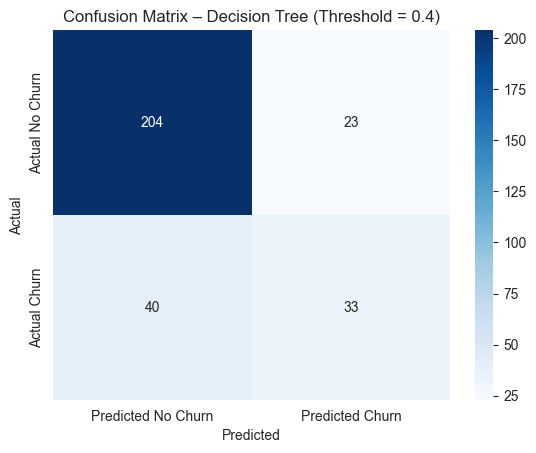

In [77]:
chosen_threshold = 0.4
y_pred_final = (y_proba_tree >= chosen_threshold).astype(int)

cm_final = confusion_matrix(y_test, y_pred_final)

sns.heatmap(
    cm_final,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted No Churn", "Predicted Churn"],
    yticklabels=["Actual No Churn", "Actual Churn"]
)
plt.title(f"Confusion Matrix – Decision Tree (Threshold = {chosen_threshold})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


### 9. Product & Business Insights (By-Product of the Model)

We want to use the model and EDA not just to predict churn, but to understand why users churn and what teams can do about it.

#### 9.1 Key Behavioral Signals Associated with Churn

Based on EDA, model behavior, and decision tree logic, the following patterns consistently appear:

##### Low Engagement (sessions_per_week)


- Users who log in infrequently are more likely to churn

- Engagement decline is often an early signal

**Product / Marketing Action**

- Trigger re-engagement nudges when sessions drop (reaction to change in behavior)

- Surface quick-win features on next login ("Did you know you can automate X in 1 click?")

- Send reminders tied to unfinished tasks or value moments

##### Shallow Feature Adoption (feature_usage)

- Users using fewer features show higher churn risk

- Breadth of adoption matters more than mastery of one feature

**Product / UX Action**

- Improve onboarding to highlight core features

- Progressive feature discovery (tips, checklists)

- Personalized in-app guidance for underused features

##### Short Tenure (tenure_months)

- Newer users are more vulnerable to churn

- Early experience is critical

**Product Action**

- Focus retention efforts in the first weeks

- Onboarding milestones instead of generic tutorials

- Early “success moments” within first sessions

##### Support Friction (support_tickets)

- A small group of users generates repeated tickets

- These users represent concentrated churn risk

**Support / Product Action**

- Flag repeat-ticket users for proactive follow-up

- Improve self-service or UX around common issues

- Use ticket topics to prioritize product fixes

#### 9.2 Segment-Aware Retention Strategies

*The same churn signal should not trigger the same action for every user.*

<u>Premium vs Free Users</u>

**Premium users**

1. Higher revenue impact

2. Fewer users, higher value

<u>Actions</u>

1. Lower churn threshold (even more aggressive)

2. White-glove support

3. Personalized outreach

------

**Free / Basic users**

1. Higher volume

2. Lower individual cost

<u>Actions</u>

1. Automated campaigns

2. In-product messaging

3. Feature-led upsell retention

#### 9.3 How Marketing Should Use the Model

Instead of a binary decision, the model enables:

- Risk-based targeting

- Tiered outreach strategies

- Budget optimization

<u>Example:</u>

High risk + premium → human follow-up

Medium risk → targeted email

Low risk → no action

#### 9.4 Product Feedback Loop

*The model is a decision support tool, not a replacement for product judgment.*

This model should not live in isolation.

<u>How to close the loop:</u>

- Track which retention actions work

- Feed outcomes back into the model

- Refine features and thresholds over time

TO SUMMARIZE:

The churn model highlights **engagement**, **feature adoption**, and **early lifecycle experience** as key drivers of retention risk. These insights enable targeted product and marketing interventions, particularly during onboarding and periods of declining usage. By combining model predictions with segment-specific actions, XYZ can proactively reduce churn while improving user experience.

### 10. Final Synthesis

We built a churn prediction model to proactively identify users at risk of canceling their subscription within the next 30 days, with the explicit goal of minimizing missed churners while maintaining transparency and operational feasibility. After evaluating multiple simple and explainable models, a decision tree emerged as the best fit, delivering the highest recall for churned users while remaining easy to interpret. By adjusting the decision threshold, we intentionally prioritized recall over precision, reflecting the low cost of outreach relative to the high cost of lost customers. Beyond prediction, the analysis revealed that declining engagement, shallow feature adoption, early-stage usage, and repeated support interactions are key churn signals. These insights enable targeted, segment-specific retention actions—such as early onboarding interventions, feature discovery nudges, and proactive support—positioning the model not as an isolated prediction tool, but as a foundation for smarter, data-informed retention strategies.